In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
from PIL import Image
import json
from sklearn.utils import shuffle
from cache import cache
import pydot
import graphviz
from sklearn.model_selection import train_test_split
from time import time
import pickle
from tqdm import tqdm

In [2]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, GRU, LSTM, Embedding, Dropout,TimeDistributed, RepeatVector,\
Activation, Flatten, Reshape, concatenate, BatchNormalization

from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.applications.inception_v3 import InceptionV3
from tensorflow.python.keras.applications.inception_v3 import preprocess_input as InceptionV3_preprocess_input
from tensorflow.python.keras.applications.vgg16 import preprocess_input as VGG16_preprocess_input
from tensorflow.python.keras.preprocessing import image

from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

from tensorflow.python.keras.utils import plot_model
from tensorflow.python.keras.layers.merge import add
from tensorflow.python.keras.utils import to_categorical

In [3]:
tf.__version__

'1.14.0'

In [4]:
tf.keras.__version__

'2.2.4-tf'

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 942712811074267088
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3908130624341482539
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4050587667885028175
physical_device_desc: "device: XLA_GPU device"
]


In [6]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

# Download Data

In [7]:
os.path.abspath('.')

'/home/catnado/w266/final_project/Image_Caption'

In [8]:
# download caption file
if not os.path.exists(os.path.abspath('.') + '/annotations/'):
    annotation_zip = tf.keras.utils.get_file('captions.zip', 
                                              cache_subdir=os.path.abspath('.'),
                                              origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                              extract = True)
    annotation_file_train = os.path.abspath('.')+'/annotations/captions_train2014.json'
    annotation_file_val = os.path.abspath('.')+'/annotations/captions_val2014.json'
else:
    annotation_file_train = os.path.abspath('.')+'/annotations/captions_train2014.json'
    annotation_file_val = os.path.abspath('.')+'/annotations/captions_val2014.json'
    

In [9]:
print(annotation_file_train)
print(annotation_file_val)

/home/catnado/w266/final_project/Image_Caption/annotations/captions_train2014.json
/home/catnado/w266/final_project/Image_Caption/annotations/captions_val2014.json


In [10]:
train_path = os.path.abspath('.')+'/train2014/'

In [10]:
# # download training set image file
# name_of_zip = 'train2014.zip'
# if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
#     image_zip = tf.keras.utils.get_file(name_of_zip,
#                                         cache_subdir=os.path.abspath('.'),
#                                         origin = 'http://images.cocodataset.org/zips/' + name_of_zip,
#                                         extract = True)
#     train_path = os.path.dirname(image_zip)+'/train2014/'
# else:
#     train_path = os.path.abspath('.')+'/train2014/'

In [11]:
# # download validation set image file
# name_of_zip = 'val2014.zip'
# if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
#     image_zip = tf.keras.utils.get_file(name_of_zip,
#                                         cache_subdir=os.path.abspath('.'),
#                                         origin = 'http://images.cocodataset.org/zips/' + name_of_zip,
#                                         extract = True)
#     val_path = os.path.dirname(image_zip)+'/val2014/'
# else:
#     val_path = os.path.abspath('.')+'/val2014/'

In [12]:
# print(train_path)
# print(val_path)

/home/catnado/w266/final_project/Image_Caption/train2014/
/home/catnado/w266/final_project/Image_Caption/val2014/


### Load data and limit size to 40,000

In [11]:
# Read the json file
with open(annotation_file_train, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = train_path + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# Select the first 30000 captions from the shuffled set
num_examples = 40000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [12]:
len(train_captions), len(img_name_vector), len(all_captions)

(40000, 40000, 414113)

### Full data

In [13]:
# load training set
with open(annotation_file_train, 'r') as f:
    annotations = json.load(f)
    
# storing the captions and the image name in vectorsa
filenames_train = []
captions_train = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = train_path + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    filenames_train.append(full_coco_image_path)
    captions_train.append(caption)
    
unique_image_train = len(annotations['images'])

In [ ]:
# # load validation set
# with open(annotation_file_val, 'r') as f:
#     annotations = json.load(f)
    
# # storing the captions and the image name in vectors
# filenames_val = []
# captions_val = []

# for annot in annotations['annotations']:
#     caption = '<start> ' + annot['caption'] + ' <end>'
#     image_id = annot['image_id']
#     full_coco_image_path = val_path + 'COCO_val2014_' + '%012d.jpg' % (image_id)

#     filenames_val.append(full_coco_image_path)
#     captions_val.append(caption)

# unique_image_val = len(annotations['images'])

In [14]:
print("training set image: " + str(len(filenames_train)))
print("training set unique image: " + str(unique_image_train))
print("training set caption: " + str(len(captions_train)))

# print("validation set image: " + str(len(filenames_val)))
# print("validation set unique image: " + str(unique_image_val))
# print("validation set caption: " + str(len(captions_val)))

training set image: 414113
training set unique image: 82783
training set caption: 414113


# Show Image

In [15]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

In [16]:
def show_image(path, caption):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    #path = filenames_train[idx]
    #caption = captions_train[idx]

    # Print the captions for this image.
    print(caption)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

<start> a group of people make their way to a air plane  <end>


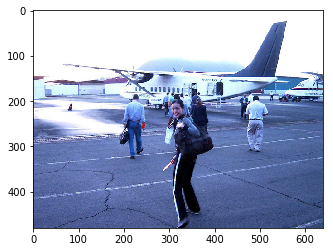

In [17]:
show_image(img_name_vector[1010], train_captions[1010])

# Encode Images with InceptionV3

In [18]:
# unique images
unique_images_train = sorted(set(filenames_train))
# unique_images_val = sorted(set(filenames_val))

In [17]:
# Get the InceptionV3 model trained on imagenet data
image_model = InceptionV3(weights='imagenet')
# Remove the last layer (output softmax layer) from the inception v3
image_model_new = Model(image_model.input, image_model.layers[-2].output)

W0723 00:10:41.807912 140106320090944 deprecation.py:506] From /home/catnado/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [19]:
image_model_new.output

<tf.Tensor 'avg_pool/Mean:0' shape=(?, 2048) dtype=float32>

In [20]:
def encode_image(path):
    # Convert all the images to size 299x299 as expected by the
    # inception v3 model
    img = image.load_img(path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess images using preprocess_input() from inception module
    x = InceptionV3_preprocess_input(x)
    x = image_model_new.predict(x)
    # reshape from (1, 2048) to (2048, )
    x = np.reshape(x, x.shape[1])
    return x

In [19]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once

if not os.path.exists(os.path.abspath('.') + '/transfer_values/InceptionV3_layer-2_train.pkl'):
    start = time()
    encoded_image_train = []
    for img in unique_images_train:
        encoded_image_train.append(encode_image(img))
    print("Time taken in minutes =", (time()-start)/60)

    # create a dictionary
    encoded_image_train_dict = dict(zip(unique_images_train, encoded_image_train))

    # Save the bottleneck train features to disk
    with open(os.path.abspath('.') + "/transfer_values/InceptionV3_layer-2_train.pkl", "wb") as encoded_pickle:
        pickle.dump(encoded_image_train_dict, encoded_pickle)
        
else:
    with open(os.path.abspath('.') + "/transfer_values/InceptionV3_layer-2_train.pkl", mode='rb') as file:
        encoded_image_train_dict = pickle.load(file)
# Time taken in minutes = 175.7973826487859

In [20]:
len(encoded_image_train_dict)

82783

In [108]:
# # Call the funtion to encode all the val images
# # This will take a while on CPU - Execute this only once

# if not os.path.exists(os.path.abspath('.') + '/transfer_values/InceptionV3_layer-2_val.pkl'):
#     start = time()
#     encoded_image_val = []
#     for img in unique_images_val:
#         encoded_image_val.append(encode_image(img))
#     print("Time taken in minutes =", (time()-start)/60)

#     # create a dictionary
#     encoded_image_val_dict = dict(zip(unique_images_val, encoded_image_val))

#     # Save the bottleneck train features to disk
#     with open(os.path.abspath('.') + "/transfer_values/InceptionV3_layer-2_val.pkl", "wb") as encoded_pickle:
#         pickle.dump(encoded_image_val_dict, encoded_pickle)
        
# else:
#     with open(os.path.abspath('.') + "/transfer_values/InceptionV3_layer-2_val.pkl", mode='rb') as file:
#         encoded_image_val_dict = pickle.load(file)

Time taken in minutes = 71.74488641421


In [21]:
img_encoding_vector = [encoded_image_train_dict[i] for i in img_name_vector]
len(img_encoding_vector)

40000

# Tokenize

In [22]:
vocab_size = 8000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)

word_index = {key:value for key, value in tokenizer.word_index.items() if value <= vocab_size}
word_index['<pad>'] = 0
vocab_size += 1
index_word = {value:key for key, value in word_index.items()}

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = pad_sequences(train_seqs, padding='post')

# max number of tokens
num_tokens = [len(t) for t in train_seqs]
max_tokens = np.max(num_tokens)

In [23]:
train_captions[:5]

['<start> A skateboarder performing a trick on a skateboard ramp. <end>',
 '<start> a person soaring through the air on skis <end>',
 '<start> a wood door with some boards laid against it <end>',
 '<start> A Do Not Enter sign is posted along a road leading to a stadium. <end>',
 '<start> Small child in a high chair eating off of a green plate.  <end>']

In [24]:
train_seqs[:5]

[[3, 2, 356, 674, 2, 277, 5, 2, 83, 342, 4],
 [3, 2, 29, 2486, 108, 7, 133, 5, 156, 4],
 [3, 2, 304, 270, 9, 28, 542, 1100, 308, 31, 4],
 [3, 2, 1101, 768, 1642, 57, 11, 1102, 222, 2, 89, 963, 13, 2, 1292, 4],
 [3, 37, 157, 8, 2, 359, 160, 122, 216, 6, 2, 66, 41, 4]]

In [25]:
cap_vector[:5]

array([[   3,    2,  356,  674,    2,  277,    5,    2,   83,  342,    4,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   3,    2,   29, 2486,  108,    7,  133,    5,  156,    4,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   3,    2,  304,  270,    9,   28,  542, 1100,  308,   31,    4,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   

# Split Data

In [26]:
# Splitting to training, validation, test sets with 30K, 5K, 5K respectively
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.25,
                                                                    random_state=0)

img_name_val, img_name_test, cap_val, cap_test = train_test_split(img_name_val,
                                                                    cap_val,
                                                                    test_size=0.5,
                                                                    random_state=0)

In [27]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val), len(img_name_test), len(cap_test)

(30000, 30000, 5000, 5000, 5000, 5000)

[  3   2  12  22  13   2  52 264 161   8   7  52   4   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0]


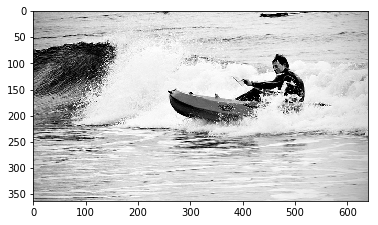

In [28]:
show_image(img_name_train[6], cap_train[6])

In [29]:
# Splitting to training, validation, test sets with 30K, 5K, 5K respectively
img_encoding_train, img_encoding_val, seqs_train, seqs_val = train_test_split(img_encoding_vector,
                                                                    train_seqs,
                                                                    test_size=0.25,
                                                                    random_state=0)

img_encoding_val, img_encoding_test, seqs_val, seqs_test = train_test_split(img_encoding_val,
                                                                    seqs_val,
                                                                    test_size=0.5,
                                                                    random_state=0)

In [99]:
len(img_encoding_train), len(seqs_train), len(img_encoding_val), len(seqs_val), len(img_encoding_test), len(seqs_test)

(30000, 30000, 5000, 5000, 5000, 5000)

In [31]:
seqs_train[6]

[3, 2, 12, 22, 13, 2, 52, 264, 161, 8, 7, 52, 4]

# GloVe Embedding

In [32]:
# download caption file
if not os.path.exists(os.path.abspath('.') + '/GloVe/'):
    glove_zip = tf.keras.utils.get_file('glove_6B.zip',
                                        cache_subdir=os.path.abspath('.'),
                                        origin = 'https://nlp.stanford.edu/data/glove.6B.zip',
                                        extract = True)

In [33]:
# Load Glove vectors
glove_dir = os.path.abspath('.') + '/GloVe'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [34]:
embedding_dim = 200
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [35]:
embedding_matrix.shape

(8001, 200)

# Merge Model

In [125]:
# build model
max_length = max_tokens - 1 #because will shift input output by 1

inputs1 = Input(shape=(2048,)) #image encoding
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,)) #caption
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = GRU(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [126]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 48)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 48, 200)      1600200     input_6[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 2048)         0           input_5[0][0]                    
____________________________________________________________________________________________

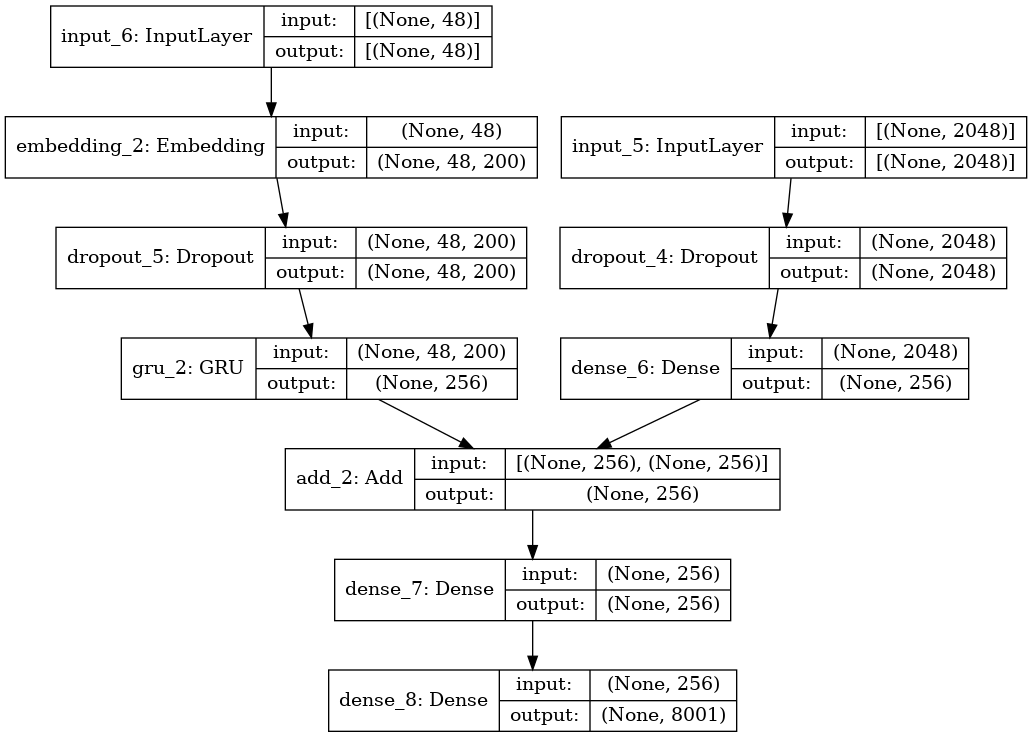

In [127]:
plot_model(model, to_file='merge_model.png', show_shapes=True)

### Freeze embedding layer with glove weights

In [128]:
model.layers[2]

In [129]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

### Generate data

In [130]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(image_vector, caption_vector, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop over images
    while 1:
        for i in range(len(image_vector)):
            n+=1
            photo_feature = image_vector[i]
            seq = caption_vector[i]
            
            for j in range(1, len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:j], seq[j]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')
                in_seq = in_seq.reshape((in_seq.shape[1],))
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)
                out_seq = out_seq.reshape((out_seq.shape[1],))
                # store
                X1.append(photo_feature)
                X2.append(in_seq)
                y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [np.array(X1), np.array(X2)], np.array(y)
                X1, X2, y = list(), list(), list()
                n=0

### Fit model

In [132]:
model.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop')

In [133]:
epochs = 1
number_pics_per_batch = 5
steps = len(img_encoding_train)//number_pics_per_batch

for i in range(epochs):
    generator = data_generator(img_encoding_train, seqs_train, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=2)
    model.save('./merge_model_weights/model_' + str(i) + '.h5')

200/200 - 29s - loss: 5.5985
200/200 - 27s - loss: 4.5995
200/200 - 27s - loss: 4.2515
200/200 - 27s - loss: 4.0116
200/200 - 27s - loss: 3.8359
200/200 - 27s - loss: 3.6864
200/200 - 27s - loss: 3.5297
200/200 - 26s - loss: 3.4129
200/200 - 26s - loss: 3.2929
200/200 - 26s - loss: 3.1783


In [98]:
max_length

48

In [101]:
seqs_train[0]

[3, 2, 641, 430, 2, 74, 19, 2, 51, 87, 4]

# Generate Caption

In [87]:
# Load Model
model.load_weights('./merge_model_weights/model_7.h5')

### Greedy search

In [134]:
def greedySearch(photo):
    in_text = '<start>'
    for i in range(max_length):
        sequence = [word_index[w] for w in in_text.split() if w in word_index]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        yhat = model.predict([photo.reshape(1,2048),sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_word[yhat]
        in_text += ' ' + word
        if word == '<end>':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [48]:
photo = img_encoding_train[3]

In [78]:
yhat = model.predict([photo.reshape(1,2048),sequence], verbose=0)

In [79]:
yhat = np.argmax(yhat)
word = index_word[yhat]
word

'dog'

In [80]:
in_text += ' ' + word
sequence = [word_index[w] for w in in_text.split() if w in word_index]
sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

In [81]:
sequence

array([[ 3,  2, 12,  8,  2, 45, 10,  2, 45,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
      dtype=int32)

[  3   2 187  26   2 554   8  42   6   2  21  63 119   4   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0]


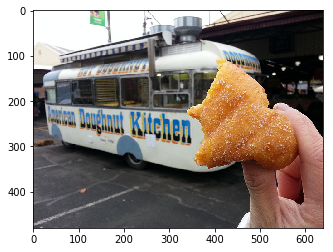

a man is is a a white and a blue and white and a man walking a a skateboard


In [163]:
idx = 3
show_image(img_name_train[idx], cap_train[idx])
print(greedySearch(img_encoding_train[idx]))

In [253]:
greedySearch(img_encoding_vector[5])

'two people standing next to each other on a a hole'

iter1:
input:
[2,0,0,0,0]

prediction:
word: [3,7,19,25,5]
prob: [0.1,0.3,0.5,0.2,0.2]

[2,3,0,0,0] : 0,1
[2,7,0,0,0] : 0.3
[2,19,0,0,0] : 0.5
[2,25,0,0,0] : 0.2
[2,5,0,0,0] : 0.2

iter2:
input:
[2,3,0,0,0] : 0,1
[2,7,0,0,0] : 0.3
[2,19,0,0,0] : 0.5
[2,25,0,0,0] : 0.2
[2,5,0,0,0] : 0.2

1)
[2,3,4,0,0] : 0.1 x 0.01
[2,3,8,0,0] : 0.1 x 0.3
[2,3,12,0,0] : 0.1 x 0.4
[2,3,23,0,0] : 0.1 x 0.002
[2,3,6,0,0] : 0.1 x 0.13

In [290]:
sequence = []
sequence.append(word_index['<start>'])
sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
sequence

array([[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0]], dtype=int32)

In [291]:
image_features = img_encoding_vector[5].reshape(1,2048)

In [306]:
yhat = model.predict([image_features,sequence], verbose=0)

In [307]:
token = np.argsort(yhat[0])[-3:][::-1]

In [308]:
prob = yhat[0][word]

In [309]:
token

array([ 16,   2, 333])

In [310]:
prob

array([0.6195098 , 0.15704824, 0.09064878], dtype=float32)

In [ ]:
all_candidate[[seq, prob], 
              [seq, prob], 
              [seq, prob], ...]

In [6]:
test1 = [0, 0, 0, 1, 2, 3, 4, 5, 6]
for i in range(len(test1)):
    if test1[0] == 0:
        test1.pop(0)

print(test1)

[1, 2, 3, 4, 5, 6]


In [ ]:
# beam search
def beamSearch(photo, beam_width=k, max_length):
    
    image_features = photo.reshape(1,2048)
    seq = word_index['<start>']
    prob = 1
    all_candidates = [(seq, prob)]
    current_candidates = []
    count = 1

    while count <= max_length:
        for i in range(len(all_candidates)):
            seq, prob = all_candidates[i]
            
            if seq[-1] == word_index['<end>']:
                current_candidates.extend((seq, prob))
            else:
                seq_pad = pad_sequences([seq], maxlen=max_length, padding='post')
                yhat = model.predict([image_features,seq_pad], verbose=0)

                pred_word = np.argsort(yhat[0])[-k:][::-1]
                pred_prob = yhat[0][pred_word]

                pred_prob = prob * pred_prob
                pred_seq = [seq.append(i) for i in pred_word]

                current_candidates.extend(zip(pred_seq, pred_prob))
        
        ordered = sorted(current_candidates, key=lambda tup:tup[1], reverse=True)
        all_candidates = ordered[:k]
        current_candidates = []
        count += 1

        # stop if all seq have reached end of sentence token
        stop = 1
        for candidate in all_candidates:
            if candidate[0][-1] != word_index['<end>']:
                stop = 0
                break
        if stop == 1:
            break
                     
    seq, prob = zip(*all_candidates)
    final = seq[np.argmax(prob)]
    final = [index_word(i) for i in final if i != 0]
    final = final[1:-1]
    final = ' '.join(final)
    
    return final


In [164]:
photo = img_encoding_train[3]
image_features = photo.reshape(1,2048)
seq = word_index['<start>']
prob = 1
all_candidates = [(seq, prob)]
current_candidates = []
count = 1

# Evaluate Model

In [ ]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# Inject Model

In [ ]:
state_size = 512
embedding_size = 128

# encoder
encoder_input = Input(shape=(transfer_values_size,), name='encoder_input')
encoder_output = Dense(state_size, activation='tanh', name='encoder_output') 
# using tanh to get to -1 to 1 in order to use as initial state

# decoder
decoder_input = Input(shape=(None, ), name='decoder_input')
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_size, name='decoder_embedding')
decoder_gru1 = GRU(state_size, return_sequences=True, name='decoder_gru1')
decoder_gru2 = GRU(state_size, return_sequences=True, name='decoder_gru2')
decoder_gru3 = GRU(state_size, return_sequences=True, name='decoder_gru3')
decoder_dense = Dense(vocab_size, activation='softmax', name='decoder_output')

# connect layers
initial_state = encoder_output(encoder_input)
net = decoder_embedding(decoder_input)
net = decoder_gru1(net, initial_state=initial_state)
net = decoder_gru2(net, initial_state=initial_state)
net = decoder_gru3(net, initial_state=initial_state)
decoder_output = decoder_dense(net)


# connect and create model
model = Model(inputs=[encoder_input, decoder_input], outputs=decoder_output)


In [ ]:
print(model.summary())

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
# checkpoint
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
callback_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# tensorboard
callback_tensorboard = TensorBoard(log_dir='./tensorboard_logs/', histogram_freq=0, write_graph=False)

callbacks = [callback_checkpoint, callback_tensorboard]

In [ ]:
# load model
try:
    model.load_weights(filepath)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [ ]:
# compile model
rms = RMSprop(lr=0.001)  #RMS prop works better than adam for RNN models
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=rms)


In [ ]:
check_X1train = 

In [ ]:
# fit model
# should train for 20, try 1 for now
%time
model.fit([check_X1train, check_X2train], check_ytrain, epochs=3, verbose=2, callbacks=callbacks, 
          validation_data=([check_X1val, check_X2val], check_yval))

# Generate Caption

In [ ]:
def generate_caption(idx, max_tokens=51):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # input X1: transfer values
    transfer_values = X1train[idx].reshape((1, 4096))
    
    # input X2: word token
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    token_int = tokenizer.word_index['<start>']
    token_end = tokenizer.word_index['<end>']
    output_text = ''
    count_tokens = 0


    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        
        decoder_input_data[0, count_tokens] = token_int
        decoder_output = model.predict([transfer_values, decoder_input_data])
        token_onehot = decoder_output[0, count_tokens, :]
        token_int = np.argmax(token_onehot)
        if token_int != 0:
            sampled_word = index_word[token_int]
            output_text += " " + sampled_word
        else:
            break
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
    show_image(idx)
    
    # Print the predicted caption.
    print("Predicted caption:")
    print(output_text)
    print()